# Blackbox Metamodel Demo of a Classification Task

The `MetamodelClassification` class allows for adding uncertainty prediction to any blackbox model (referred to as `base` model here). The blackbox model may either pre-exist (and be supplied by the user) or be created inside `MetamodelClassification`.

Note: The term "blackbox" refers to the assumption that only the inputs and outputs of such a model can be observed. There is no access to its internal parameters.


#### Import Statements

In [ ]:
%matplotlib inline

In [1]:
import matplotlib.pyplot as plt

In [6]:
from uq360.algorithms.blackbox_metamodel import MetamodelClassification
from uq360.metrics.classification_metrics import plot_risk_vs_rejection_rate

In [7]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import pandas as pd

#### Load Digits Dataset

In [8]:
digits_dataset = datasets.load_digits()

In [9]:
X, y = digits_dataset['data'], digits_dataset['target']

#### Train test split of the dataset

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Example 1: Train a Blackbox Base Classification Model + Uncertainty Meta Model in One Shot

In a first example, the `MetamodelClassification` class' built-in instantiation mechanism for both the base and the meta model are used. The model type is specified "by name" (`gbm`) here.  

In [11]:
base_config = {'n_estimators': 500, 
               'max_depth': 5,
               'learning_rate': 0.001, 
               'min_samples_leaf': 10, 
               'min_samples_split': 10,
               'random_state': 42}
meta_config = {'n_estimators': 200, 
               'max_depth': 3,
               'learning_rate': 0.001, 
               'min_samples_leaf': 10, 
               'min_samples_split': 10,
               'random_state': 42}
uq_model = MetamodelClassification(base_model='gbm', meta_model='gbm', 
                                           base_config=base_config, meta_config=meta_config)

In [12]:
# this will fit both the base and the meta model 
_ = uq_model.fit(X_train, y_train)

In [13]:
y_test_pred, y_test_score = uq_model.predict(X_test)

In [14]:
print('TEST Accuracy = %.2f%%' % (100*accuracy_score(y_test, y_test_pred)))

TEST Accuracy = 89.44%


In [15]:
y_test_pred.shape

(540,)

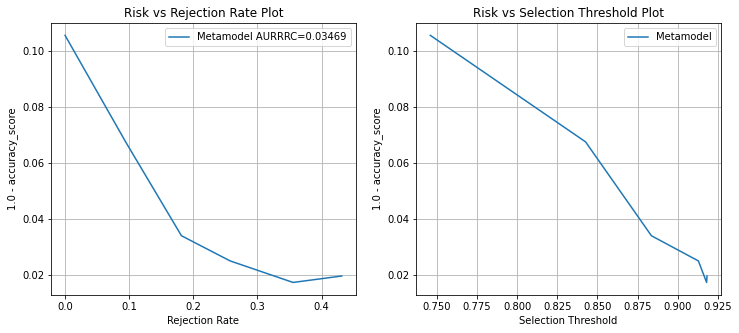

In [16]:
_ = plot_risk_vs_rejection_rate(
    y_true=y_test,
    y_prob=None,
    y_pred=y_test_pred,
    selection_scores=y_test_score,
    plot_label=['Metamodel'],
    risk_func=accuracy_score,
    num_bins=10
)

The plots above show that it is possible to use the blackbox uncertainty score in `y_prob` as confidence to filter iindividual instances of the test set. By doing so the accuracy (error) in the residual set increases (decreases).  

## Example 2: Base model has been trained externally. Just add the uncertainty model. 

In practice a base model may pre-exist and have been trained already. Moreover, the training of a base model may be expensive and the full training data may not be available, which makes an internal (re-)training of `MetamodelClassification` via `fit()` undesirable or even impossible. 
The API provides for this situation: First, we instantiate the `MetamodelClassification` using the existing base model instance. Then use the option `base_is_prefitted=True`, and an optional `meta_train_data` specification, when calling the `fit()` method.

In [17]:
# split the training partition to provide base and meta training sets
X_train_base, X_train_meta, y_train_base, y_train_meta = train_test_split(X_train, y_train, test_size=0.4, random_state=42)

In [18]:
# Simulate a pre-existing, pre-trained base model 
base_mdl = GradientBoostingClassifier(**base_config)
_ = base_mdl.fit(X_train_base, y_train_base)

In [19]:
# Create a Blackbox instance using the above and an instance of an LR model as meta model 
# Note: the meta instantiation shown here is by passing an instance (alternatives: by name 'lr', or 
# class declaration 'sklearn.linear_model.LogisticRegression')
meta_config = {'n_estimators': 150, 
               'max_depth': 2,
               'learning_rate': 0.001, 
               'min_samples_leaf': 10, 
               'min_samples_split': 10,
               'random_state': 42}
meta_mdl = GradientBoostingClassifier(**meta_config)
uq_model = MetamodelClassification(base_model=base_mdl, meta_model=meta_mdl, 
                             base_config=None, meta_config=meta_config)

In [20]:
# now fit the meta model only
_ = uq_model.fit(X=None, y=None, base_is_prefitted=True, meta_train_data=(X_train_meta, y_train_meta))

In [21]:
y_test_pred, y_test_score = uq_model.predict(X_test)

In [22]:
print('TEST Accuracy = %.2f%%' % (100*accuracy_score(y_test, y_test_pred)))

TEST Accuracy = 87.78%


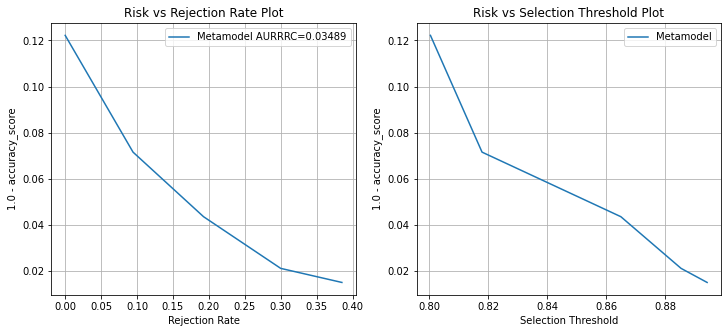

In [23]:
_ = plot_risk_vs_rejection_rate(
    y_true=y_test,
    y_prob=None,
    selection_scores=y_test_score,
    y_pred=y_test_pred,
    plot_label=['Metamodel'],
    risk_func=accuracy_score,
    num_bins = 10
)